### Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import h2o 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
import os

In [2]:
from alibi.explainers import PartialDependence, plot_pd, AnchorTabular, ALE, CEM 
from alibi.explainers.ale import plot_ale
import interpret
from interpret.blackbox import ShapKernel, LimeTabular

c:\Users\Sebastian's work\OneDrive - OptiMedis AG\Dokumente\Coding\High-Cost-patient-analysis\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# CREATE EXPLANATIONS FOR RANDOM FOREST 
**File**: 5_model_explanation.ipynb

**Author**: Sebastian Benno Veuskens 

**Date**: 2024-07-28

**Data**: Create a small data set with simple relations. 


## Modify

**Working directory**

In [3]:
os.chdir("C:/Users/Sebastian's work/OneDrive - OptiMedis AG/Dokumente/Coding/High-Cost-patient-analysis")

**Parameters & Settings**

In [4]:
target = 'HC_Patient_Next_Year'
excluded = 'Total_Costs_Next_Year'

### Load data

In [5]:
train_validate = pd.read_csv('data/complete/unbalanced/train_validate.csv', sep=',', header=0).sample(frac=0.2)
test = pd.read_csv('data/complete/unbalanced/test.csv', sep=',', header=0).sample(frac=0.2)

train_validate['Sex'] = pd.factorize(train_validate['Sex'])[0]
test['Sex'] = pd.factorize(test['Sex'])[0]
train_validate['HC_Patient'] = pd.factorize(train_validate['HC_Patient'])[0]
test['HC_Patient'] = pd.factorize(test['HC_Patient'])[0]
train_validate['HC_Patient_Next_Year'] = pd.factorize(train_validate['HC_Patient_Next_Year'])[0]
test['HC_Patient_Next_Year'] = pd.factorize(test['HC_Patient_Next_Year'])[0]

In [41]:
# predictors = train_validate.columns.difference((target, excluded))
predictors = [var for var in train_validate.columns if var not in (target, excluded)]
X_train_validate, y_train_validate = train_validate[predictors], train_validate[target]
X_test, y_test = test[predictors], test[target]

In [ ]:
X_test.head()

In [43]:
#TODO: Check if I really need this encoding (for alibi pdp plot)
from sklearn.preprocessing import OrdinalEncoder
categorical_columns_names = ['Sex', 'HC_Patient']
categorical_columns_indices = [test.columns.tolist().index(cn) for cn in categorical_columns_names]
oe = OrdinalEncoder().fit(X_train_validate[categorical_columns_names])

X_train_validate.loc[:, categorical_columns_names] = oe.transform(X_train_validate[categorical_columns_names])
X_test.loc[:, categorical_columns_names] = oe.transform(X_test[categorical_columns_names])

In [8]:
train_validate.head()

,HC_Patient_Next_Year,Total_Costs_Next_Year,HC_Patient,Sex,Age,Need_of_Care_Duration,DMP_Duration,Total_Costs,Inpatient_Num_Diagnoses,Outpatient_Num_Diagnoses,...,Prescription_S03,Prescription_V01,Prescription_V03,Prescription_V04,Prescription_V06,Prescription_V07,Prescription_V08,Prescription_V09,Prescription_V10,Prescription_V70
5186,0,0.000000,0,0,9,0,0,95.752275,0,4,...,0,0,0,0,0,0,0,0,0,0
38832,0,183.502903,0,0,21,0,0,74.411732,0,10,...,0,0,0,0,0,0,0,0,0,0
23834,0,856.288445,0,1,80,0,8,929.036878,0,64,...,0,0,0,0,0,0,0,0,0,0
34805,0,33.246109,0,1,9,0,0,0.000000,0,2,...,0,0,0,0,0,0,0,0,0,0
21994,0,252.127404,0,1,57,0,0,672.249033,0,9,...,0,0,0,0,0,0,0,0,0,0


## Model training & prediction

### scikit-learn random forest

In [44]:
model = RandomForestClassifier(n_estimators=1000, max_features=30, random_state=12345)
model.fit(X_train_validate, y_train_validate)

RandomForestClassifier(max_features=30, n_estimators=1000, random_state=12345)

In [45]:
prediction_probs = model.predict_proba(X_test)[:,1]
predictions = model.predict(X_test)

## Model evaluation
#TODO: Change all train_validate[predictors] to X_train_validate etc. 

### ROC-AUC

In [16]:
fpr, tpr, _ = roc_curve(y_test, prediction_probs)
roc_auc = auc(fpr, tpr)

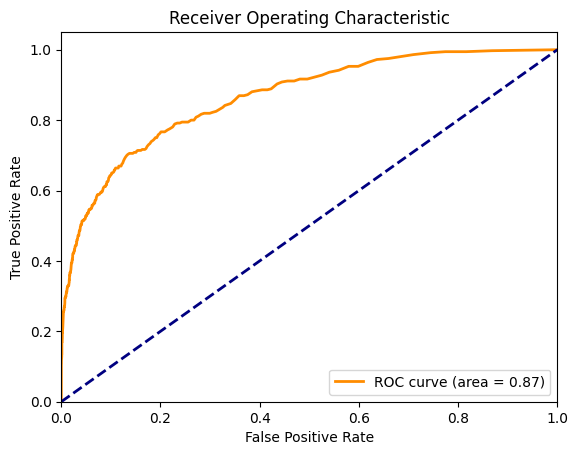

In [17]:
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Precision-Recall-AUC

In [18]:
precision, recall, _ = precision_recall_curve(y_test, prediction_probs)
pr_auc = auc(recall, precision)

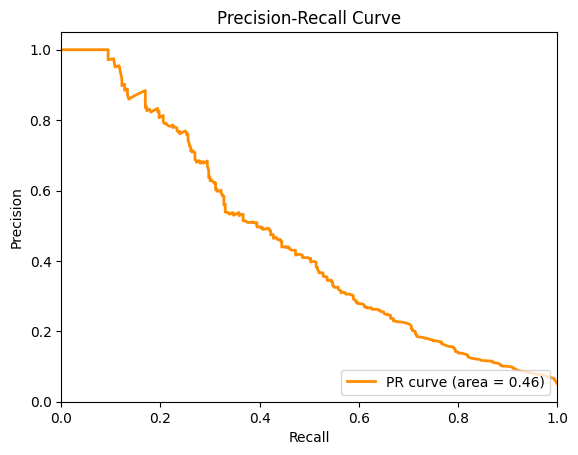

In [19]:
# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2, label='PR curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

### Confusion Matrix

In [20]:
conf_matrix = confusion_matrix(y_test, predictions)
print(conf_matrix)

[[6694   14]
 [ 293   67]]


# XAI METHODS 
## ALIBI

### PDP & ICE
Shortcomings: 

- Through data generation it might be based on "impossible" samples (can be prevented partly by conditional instead of marginal probability), data that was not included in the training data (which contains real data) -> thus predictions are not meaningful -> However, this might also help in assessing the generalizability of the model: Does it also perform well in former unknown/unseen samples? -> Robustness 
- Limited informative value for correlated features (because )

#### Modify

In [46]:
features_pdp = [('Age', 'Need_of_Care_Duration')] # [(0, 1)] -> For 2-dimensional plot
show_pdp = True
resolution = 25 # Granularity of PDP & ICE plot (how often to split the x-axis)
sample = X_test.iloc[1] # Sample to investigate better

Get the indexes of the columns I want to investigate. 

In [47]:
features = list()
for feature_group in features_pdp:
    if type(feature_group) == str:
        features.append(X_test.columns.get_loc(feature_group))
    else:
        feature_group_idx = [X_test.columns.get_loc(feat) for feat in feature_group]
        features.append(tuple(feature_group_idx))
features

[(2, 3)]

Create the explainer.

In [48]:
kind = 'average' if show_pdp else 'both'
def predict_fn_pdp(data):
    # TODO: Check if this indexing of x makes sense 
    return model.predict(data)

pdp = PartialDependence(predictor=predict_fn_pdp,
                        feature_names=list(predictors),
                        target_names=[target])

exp_pdp_ice = pdp.explain(X=X_test.values,
                  features=features,
                  kind=kind,
                  grid_resolution=resolution)

c:\Users\Sebastian's work\OneDrive - OptiMedis AG\Dokumente\Coding\High-Cost-patient-analysis\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Sebastian's work\OneDrive - OptiMedis AG\Dokumente\Coding\High-Cost-patient-analysis\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Sebastian's work\OneDrive - OptiMedis AG\Dokumente\Coding\High-Cost-patient-analysis\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Sebastian's work\OneDrive - OptiMedis AG\Dokumente\Coding\High-Cost-patient-analysis\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassi

Plot the PDP & ICE

array([[<Axes: xlabel='Age', ylabel='Need_of_Care_Duration'>]],
      dtype=object)

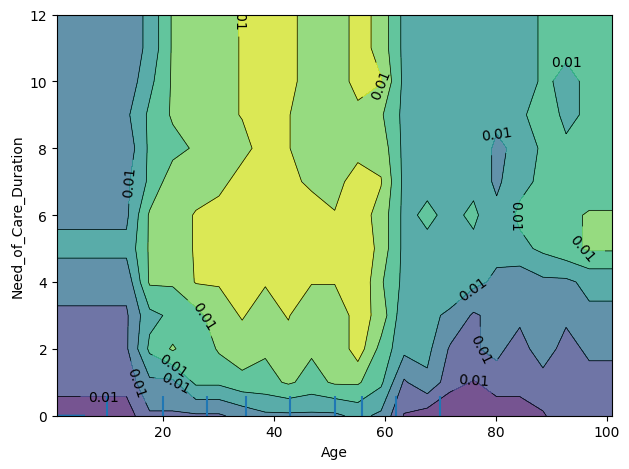

In [31]:
# fig, axis = plt.subplots()
# axis.set_ylim([0, 0.02])

# plt.ylim(0, 0.05)
plot_pd(exp_pdp_ice,
        # n_cols=2,
        sharey='row',
        # ax=axis,
        center=show_pdp)

### ALE
Measures the *differences in prediction* instead of directly averaging over predictions like pdp [here](https://docs.seldon.io/projects/alibi/en/latest/methods/ALE.html)

ALE and PDP (and probably also ICE) are methods to retrieve the *feature effects* for each feature.

#### Modify

In [33]:
features_ale = ['Age', 'Sex'] # [(0, 1)] -> For 2-dimensional plot
resolution = 25 # Granularity of PDP & ICE plot (how often to split the x-axis)
sample = X_test.iloc[1] # Sample to investigate better

In [34]:
def predict_fn_ale(x):
    return model.predict(x)

c:\Users\Sebastian's work\OneDrive - OptiMedis AG\Dokumente\Coding\High-Cost-patient-analysis\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Sebastian's work\OneDrive - OptiMedis AG\Dokumente\Coding\High-Cost-patient-analysis\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Sebastian's work\OneDrive - OptiMedis AG\Dokumente\Coding\High-Cost-patient-analysis\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Sebastian's work\OneDrive - OptiMedis AG\Dokumente\Coding\High-Cost-patient-analysis\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassi

array([[<Axes: xlabel='Age', ylabel='ALE'>,
        <Axes: xlabel='Sex', ylabel='ALE'>]], dtype=object)

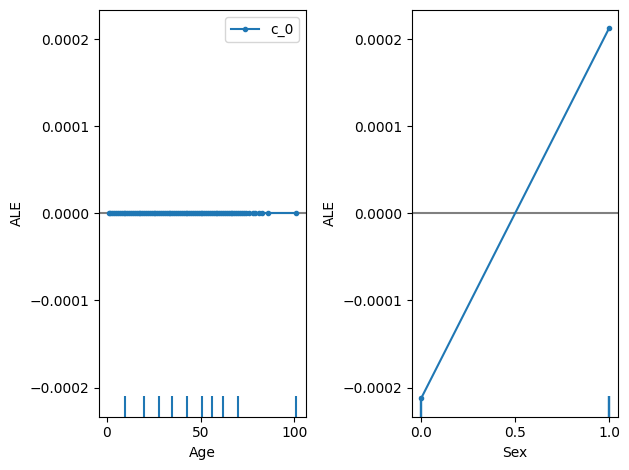

In [40]:
ale = ALE(predict_fn_ale, feature_names=list(predictors))
exp_ale = ale.explain(X_test.to_numpy(), features=[0, -2])
plot_ale(exp_ale, features=features_ale)

### Anchors

In [40]:
features_pdp = ['Age', 'Sex'] # [(0, 1)] -> For 2-dimensional plot
show_pdp = True
resolution = 25 # Granularity of PDP & ICE plot (how often to split the x-axis)
sample = X_test.iloc[1] # Sample to investigate better

Get the indexes of the columns I want to investigate. 

In [47]:
features = list()
for feature_group in features_pdp:
    if type(feature_group) == str:
        features.append(X_test.columns.get_loc(feature_group))
    else:
        feature_group_idx = [X_test.columns.get_loc(feat) for feat in feature_group]
        features.append(feature_group_idx)
features

[0, 643]

In [42]:
def predict_fn_anchors(x):
    return model.predict(x)

In [46]:
exp_anchors = AnchorTabular(predict_fn_anchors, features)
# exp_anchors.fit(X_train_validate.values, disc_perc=(25, 50, 75))
# res_anchors = exp_anchors.explain(sample.values, threshold=0.75)

## InterpretML 

**MODIFY**

In [ ]:
# TODO: Figure out what exactly I do with this number/if I should change it 
num_vars = 5    # Indicate how many samples to explain

### SHAP 

In [ ]:
shap = ShapKernel(model_sck, X_train)
shap_local = shap.explain_local(X_test[:num_vars], y_test[:num_vars])

In [ ]:
interpret.show(shap_local)

### LIME 

In [ ]:
lime = LimeTabular(model, X_train)
test_local_x = X_test[:num_vars]
test_local_y = y_test[:num_vars]

In [ ]:
exp_lime = lime.explain_local(test_local_x, test_local_y)
interpret.show(exp_lime, 0)

### PDP 

In [ ]:
pdp_iml = interpret.blackbox.PartialDependence(model, X_train)
pdp_global_iml = pdp_iml.explain_global()

In [ ]:
# TODO: Check why there is a one in interpret.show(pdp...)
interpret.show(pdp_iml.explain_global(), 1)

### Morris Sensitivity Analysis 

In [ ]:
model = model_sck if sck else model_h2o
msa_iml = interpret.blackbox.MorrisSensitivity(model, train[list(cov_names)])
msa_global_iml = msa_iml.explain_global()

In [ ]:
interpret.show(msa_global_iml, 0)

### Dashboard 

In [ ]:
interpret.show([shap_local, exp_lime, pdp_global_iml])